# Convolutional Neural Network

In this notebook you will compare the performance of a Fully Connected vs simple Convolutional Neural Networks.

In [1]:
import os
import time
import tqdm
import torch
import functools
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.utilities.seed import seed_everything

seed_everything(123)

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\utilities\seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 123


123

# Start

#### Download dataset

In this notebook you are going to work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). `Fashion-MNIST` is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


In [3]:
DATA_DIR = './data'

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms


class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir=DATA_DIR):
        super().__init__()
        
        # Hardcode some dataset specific attributes
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.5,), (0.5,)),
                                             ])
    
        # Set our init args as class attributes
        self.data_dir = data_dir
    
    def prepare_data(self):
        # download
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            data_full = datasets.FashionMNIST(self.data_dir, train=True, transform=self.transform)
            self.fmnist_train, self.fmnist_val = torch.utils.data.random_split(data_full, [50000, 10000])            

        # Assign test dataset for use in dataloader
        if stage == 'test' or stage is None:
            self.fmnist_test = datasets.FashionMNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_train, batch_size=32,
                                           shuffle=True, num_workers=2)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_val, batch_size=32,
                                           shuffle=False, num_workers=2)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.fmnist_test, batch_size=32,
                                           shuffle=False, num_workers=2)

In [5]:
label2description_list = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


fmnist_datamodule = FashionMNISTDataModule()
fmnist_datamodule.prepare_data()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



Lets display a few of dataset items:

In [6]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

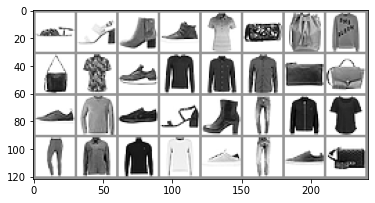

In [7]:
fmnist_datamodule.setup('fit')

dataiter = iter(fmnist_datamodule.train_dataloader())
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

#### Checking for available GPU device.

In [9]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])


if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(),)
    print('Selected %s' % (device,))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:0


# Building a baseline FC-network

## Network

Let's start with a simple baseline Fully Connected network to compare with:

In [11]:
class FashionMNISTModelFC(pl.LightningModule):

    def __init__(self, learning_rate=0.01):

        super(FashionMNISTModelFC, self).__init__()
        self.save_hyperparameters()

        # Set our init args as class attributes
        self.hparams.learning_rate = learning_rate

        # Define PyTorch model layers
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torchmetrics.functional.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer
    

By using the `Trainer` you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [13]:
# Init out datamodule
dm = FashionMNISTDataModule()
dm.prepare_data()

# Init our model
fmnist_model = FashionMNISTModelFC().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 401 K 
1 | fc2  | Linear | 51.3 K
2 | fc3  | Linear | 1.0 K 
--------------------------------
454 K     Trainable params
0         Non-trainable params
454 K     Total params
1.817     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Testing

To test a model, call `trainer.test(model)`.

Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically test using the best saved checkpoint (conditioned on val_loss).

In [14]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_0\checkpoints\epoch=9-step=15630.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_0\checkpoints\epoch=9-step=15630.ckpt
C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.859499990940094
        val_loss            0.3906978368759155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.3906978368759155, 'val_acc': 0.859499990940094}]

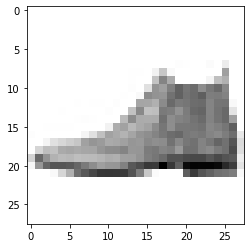

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.621
	Sneaker: 0.209
	Sandal: 0.167


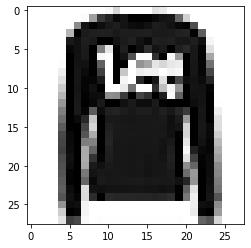

True label: Pullover
Top 3 predictions:
	Pullover: 0.968
	Coat: 0.025
	Shirt: 0.007


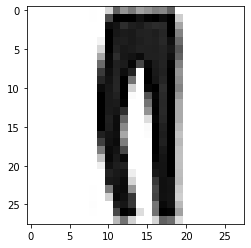

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Coat: 0.000


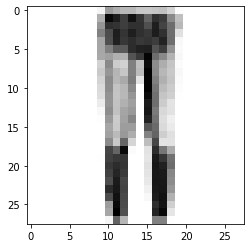

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


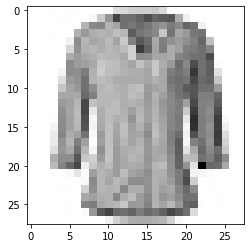

True label: Shirt
Top 3 predictions:
	Shirt: 0.761
	T-shirt/top: 0.130
	Pullover: 0.079


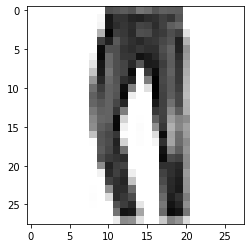

True label: Trouser
Top 3 predictions:
	Trouser: 0.992
	T-shirt/top: 0.006
	Coat: 0.001


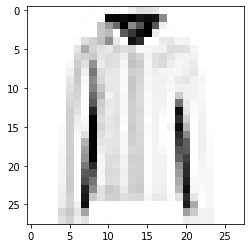

True label: Coat
Top 3 predictions:
	Coat: 0.986
	Shirt: 0.008
	Pullover: 0.005


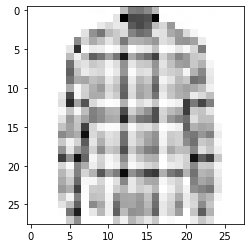

True label: Shirt
Top 3 predictions:
	Shirt: 0.803
	Coat: 0.183
	Pullover: 0.013


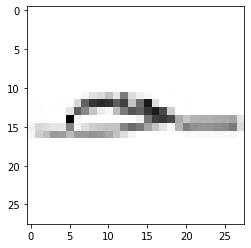

True label: Sandal
Top 3 predictions:
	Sandal: 0.940
	Sneaker: 0.055
	Pullover: 0.002


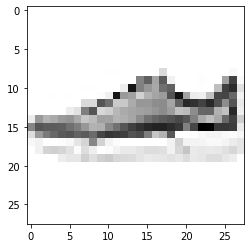

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.995
	Sandal: 0.004
	Ankle boot: 0.000


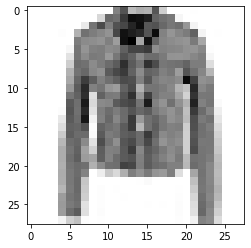

True label: Coat
Top 3 predictions:
	Coat: 0.912
	Pullover: 0.066
	Shirt: 0.020


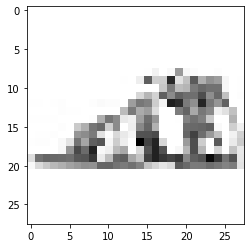

True label: Sandal
Top 3 predictions:
	Sandal: 0.982
	Sneaker: 0.015
	Ankle boot: 0.002


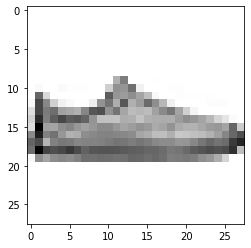

True label: Sneaker
Top 3 predictions:
	Sandal: 0.577
	Sneaker: 0.379
	Bag: 0.040


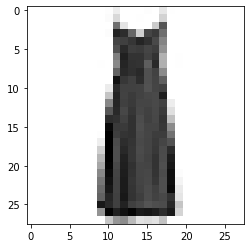

True label: Dress
Top 3 predictions:
	Dress: 0.991
	Trouser: 0.009
	T-shirt/top: 0.000


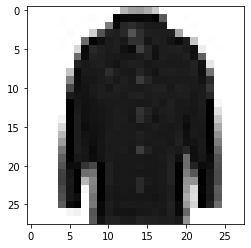

True label: Coat
Top 3 predictions:
	Coat: 0.968
	Pullover: 0.017
	Shirt: 0.008


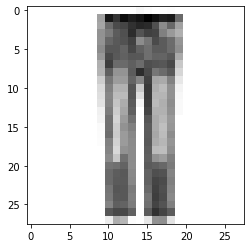

True label: Trouser
Top 3 predictions:
	Trouser: 0.997
	Dress: 0.003
	Coat: 0.000


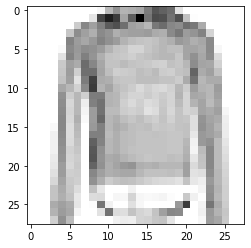

True label: Pullover
Top 3 predictions:
	Pullover: 0.979
	T-shirt/top: 0.011
	Shirt: 0.004


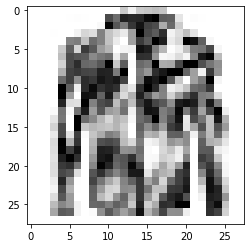

True label: Coat
Top 3 predictions:
	Pullover: 0.634
	Coat: 0.325
	Shirt: 0.035


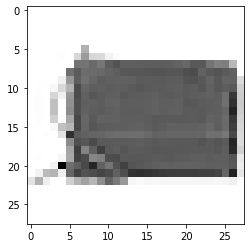

True label: Bag
Top 3 predictions:
	Bag: 0.998
	Sandal: 0.001
	Shirt: 0.001


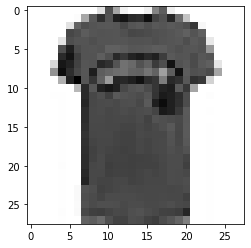

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.912
	Shirt: 0.086
	Dress: 0.001


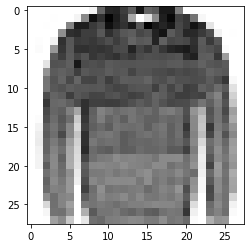

True label: Pullover
Top 3 predictions:
	Pullover: 0.662
	T-shirt/top: 0.188
	Shirt: 0.089


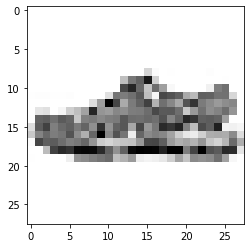

True label: Sandal
Top 3 predictions:
	Sandal: 0.657
	Sneaker: 0.341
	Ankle boot: 0.001


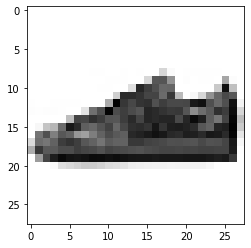

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.992
	Sandal: 0.005
	Ankle boot: 0.003


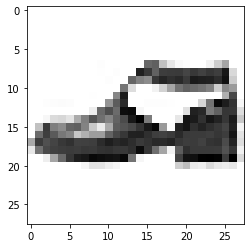

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.520
	Sneaker: 0.404
	Ankle boot: 0.073


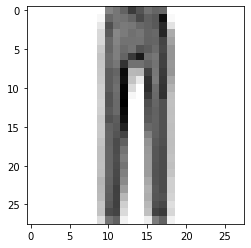

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Pullover: 0.000


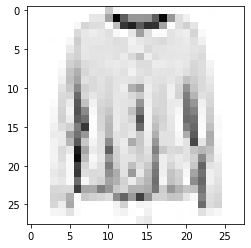

True label: Coat
Top 3 predictions:
	Pullover: 0.743
	Coat: 0.232
	Shirt: 0.022


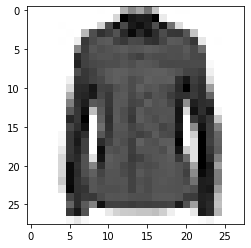

True label: Shirt
Top 3 predictions:
	Shirt: 0.781
	Coat: 0.212
	Pullover: 0.005


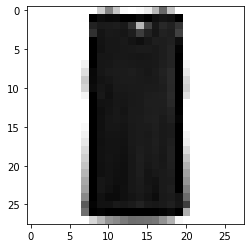

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.663
	Shirt: 0.300
	Dress: 0.031


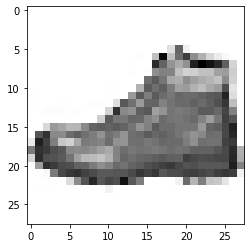

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.749
	Sneaker: 0.249
	Sandal: 0.001


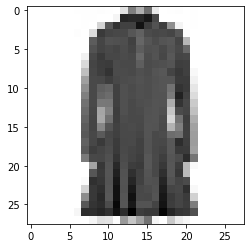

True label: Dress
Top 3 predictions:
	Shirt: 0.490
	Coat: 0.304
	Dress: 0.151


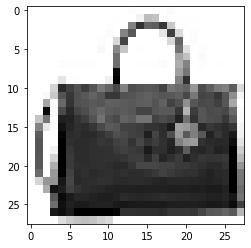

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


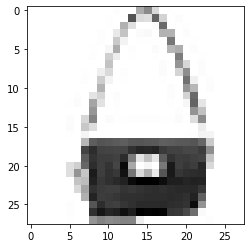

True label: Bag
Top 3 predictions:
	Bag: 0.991
	T-shirt/top: 0.003
	Dress: 0.002


In [15]:
from scipy.special import softmax

# helper function to show an image
def matplotlib_imshow_apply_model(img, true_label, prediction):
    plt.imshow(img, cmap="Greys")
    plt.show()
    print(f'True label: {label2description_list[true_label]}')
    print('Top 3 predictions:')
    probs = softmax(prediction.cpu().detach().numpy(), axis=None)
    top3_probs = np.argsort(probs)[-3:]
    for label in top3_probs[::-1]:
        print(f'\t{label2description_list[label]}: {probs[label]:.3f}')

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Building a baseline CNN-network

## Network

Let's change our network to the CNN:

In [16]:
class FashionMNISTModelCNN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.01):

        super(FashionMNISTModelCNN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.fc1 = nn.Linear(28*28*4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
# Init our model
fmnist_model = FashionMNISTModelCNN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | fc1   | Linear | 313 K 
1 | fc2   | Linear | 1.0 K 
2 | fc3   | Linear | 1.0 K 
3 | conv1 | Conv2d | 40    
---------------------------------
315 K     Trainable params
0         Non-trainable params
315 K     Total params
1.263     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Testing

C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_1\checkpoints\epoch=9-step=15630.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_1\checkpoints\epoch=9-step=15630.ckpt
C:\Users\total\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8817999958992004
        val_loss            0.3206227719783783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


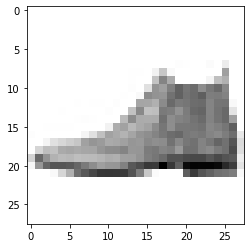

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.987
	Sneaker: 0.009
	Sandal: 0.004


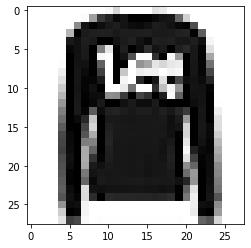

True label: Pullover
Top 3 predictions:
	Pullover: 0.994
	Shirt: 0.003
	Coat: 0.003


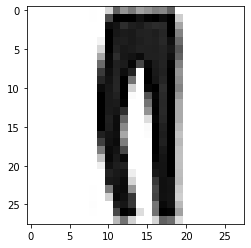

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Coat: 0.000
	Dress: 0.000


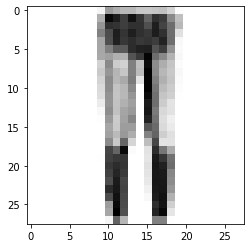

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


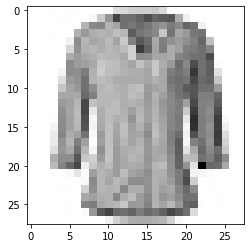

True label: Shirt
Top 3 predictions:
	Shirt: 0.954
	T-shirt/top: 0.034
	Pullover: 0.007


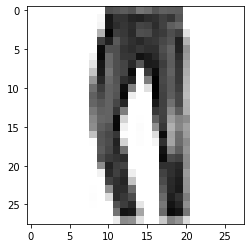

True label: Trouser
Top 3 predictions:
	Trouser: 0.998
	Shirt: 0.001
	T-shirt/top: 0.000


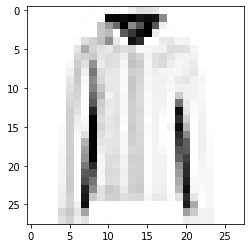

True label: Coat
Top 3 predictions:
	Coat: 0.995
	Pullover: 0.003
	Shirt: 0.002


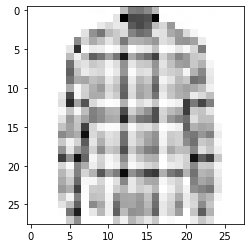

True label: Shirt
Top 3 predictions:
	Shirt: 0.997
	Coat: 0.003
	Pullover: 0.000


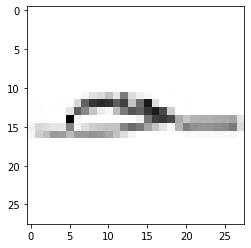

True label: Sandal
Top 3 predictions:
	Sandal: 0.985
	Sneaker: 0.009
	Bag: 0.004


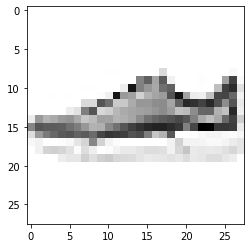

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.996
	Sandal: 0.003
	Bag: 0.001


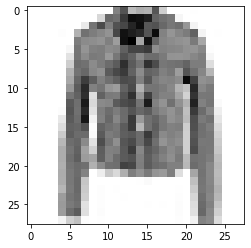

True label: Coat
Top 3 predictions:
	Coat: 0.967
	Pullover: 0.017
	Shirt: 0.016


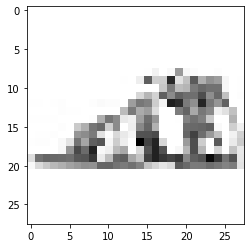

True label: Sandal
Top 3 predictions:
	Sandal: 0.995
	Shirt: 0.002
	Sneaker: 0.001


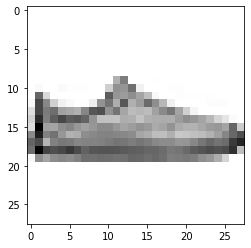

True label: Sneaker
Top 3 predictions:
	Sandal: 0.705
	Sneaker: 0.167
	Bag: 0.115


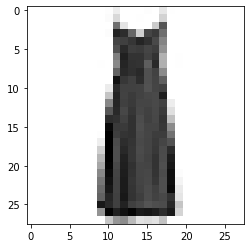

True label: Dress
Top 3 predictions:
	Dress: 0.998
	Bag: 0.001
	Ankle boot: 0.000


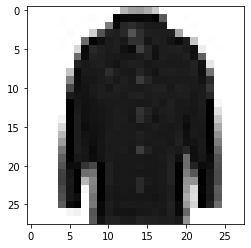

True label: Coat
Top 3 predictions:
	Coat: 0.868
	Pullover: 0.110
	Shirt: 0.021


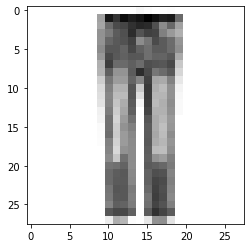

True label: Trouser
Top 3 predictions:
	Trouser: 0.995
	Dress: 0.004
	Coat: 0.001


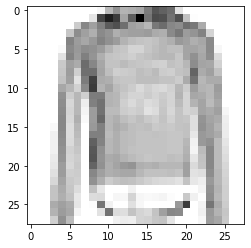

True label: Pullover
Top 3 predictions:
	Pullover: 0.935
	Shirt: 0.058
	T-shirt/top: 0.004


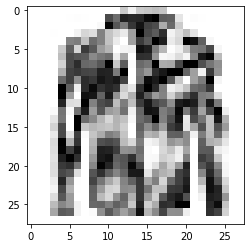

True label: Coat
Top 3 predictions:
	Coat: 0.962
	Shirt: 0.033
	Pullover: 0.005


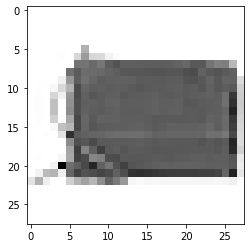

True label: Bag
Top 3 predictions:
	Bag: 0.999
	Shirt: 0.001
	Pullover: 0.000


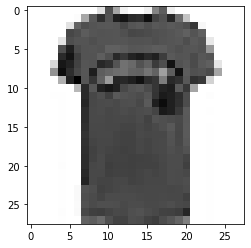

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.809
	Shirt: 0.187
	Pullover: 0.003


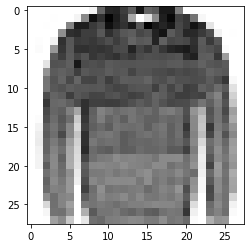

True label: Pullover
Top 3 predictions:
	Pullover: 0.949
	Shirt: 0.031
	T-shirt/top: 0.017


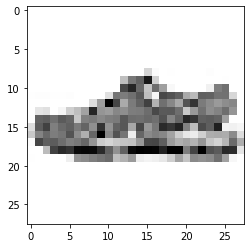

True label: Sandal
Top 3 predictions:
	Sandal: 0.945
	Sneaker: 0.050
	Ankle boot: 0.003


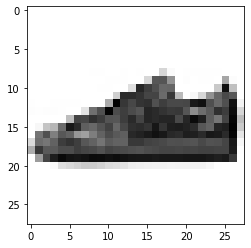

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.974
	Ankle boot: 0.019
	Sandal: 0.006


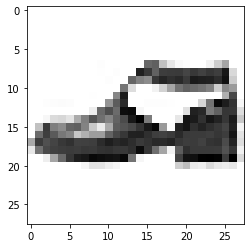

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.978
	Ankle boot: 0.013
	Sneaker: 0.008


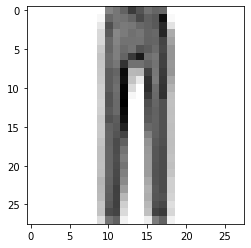

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


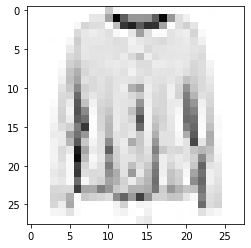

True label: Coat
Top 3 predictions:
	Shirt: 0.404
	Pullover: 0.322
	Coat: 0.272


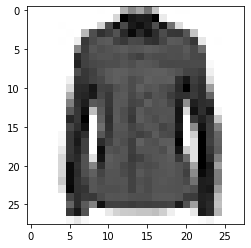

True label: Shirt
Top 3 predictions:
	Shirt: 0.980
	Coat: 0.013
	Pullover: 0.008


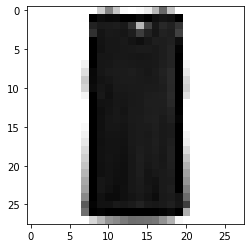

True label: T-shirt/top
Top 3 predictions:
	Shirt: 0.725
	T-shirt/top: 0.267
	Dress: 0.007


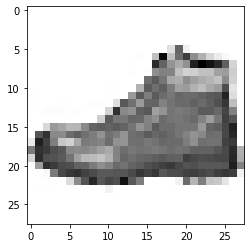

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.996
	Sneaker: 0.003
	Sandal: 0.000


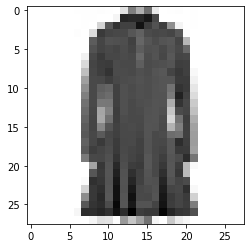

True label: Dress
Top 3 predictions:
	Shirt: 0.712
	Dress: 0.207
	Coat: 0.051


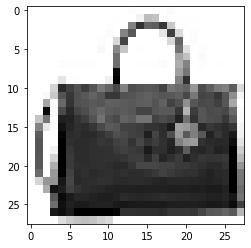

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


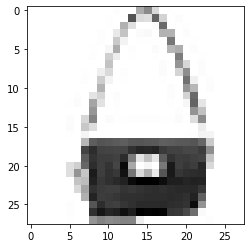

True label: Bag
Top 3 predictions:
	Bag: 0.995
	Dress: 0.002
	T-shirt/top: 0.002


In [19]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

## Result

We used only one convolutional layer, and we got better accuracy obtained using a fully connected network (although the parameters of the convolutional network were less than that of a fully connected network - **315K** versus **454K**) 

## Task 1

Now it's your turn. Impove your CNN network to achive **0.895 accuracy** on validation.

1. add one more CNN layer (with ReLU);
2. increate the number of out channels in the second CNN layer up to 16 *(so: 4 in and 16 out)*; 
3. add a fully connected layer. You should have three consecutive FC-layers like:
  * nn.Linear(12544, 1024)
  * nn.Linear(1024, 100)
  * nn.Linear(100, 10)

In [23]:
class MySuperFashionMNISTModelCNN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.01):

        super(MySuperFashionMNISTModelCNN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.fc1 = nn.Linear(12544, 1024) # 16*28*28 = 12544
        self.fc2 = nn.Linear(1024, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

The number of learning parameters has increased significantly, so we will increase the number of training steps to 20:

In [25]:
# Init our model
fmnist_model = MySuperFashionMNISTModelCNN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | fc1   | Linear | 12.8 M
1 | fc2   | Linear | 102 K 
2 | fc3   | Linear | 1.0 K 
3 | conv1 | Conv2d | 40    
4 | conv2 | Conv2d | 592   
---------------------------------
13.0 M    Trainable params
0         Non-trainable params
13.0 M    Total params
51.801    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Task 1 testing

Restoring states from the checkpoint path at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_2\checkpoints\epoch=19-step=31260.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_2\checkpoints\epoch=19-step=31260.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9017000198364258
        val_loss            0.3279646337032318
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


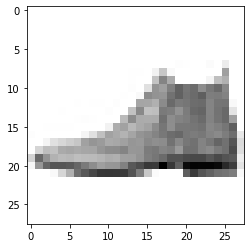

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sneaker: 0.000
	Sandal: 0.000


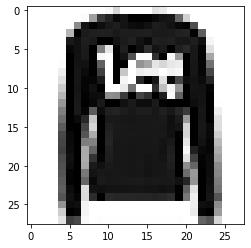

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	T-shirt/top: 0.000
	Shirt: 0.000


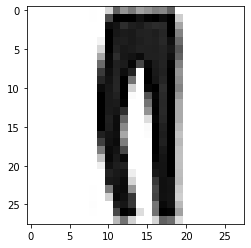

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


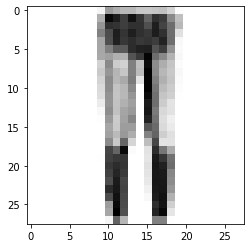

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


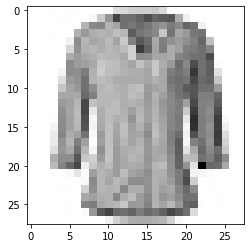

True label: Shirt
Top 3 predictions:
	Shirt: 0.993
	T-shirt/top: 0.007
	Pullover: 0.000


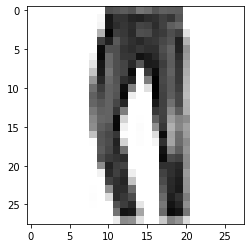

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	T-shirt/top: 0.000
	Dress: 0.000


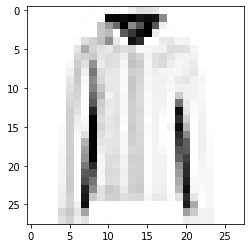

True label: Coat
Top 3 predictions:
	Coat: 1.000
	Shirt: 0.000
	Pullover: 0.000


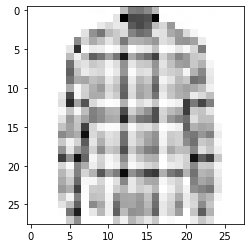

True label: Shirt
Top 3 predictions:
	Shirt: 1.000
	Coat: 0.000
	Pullover: 0.000


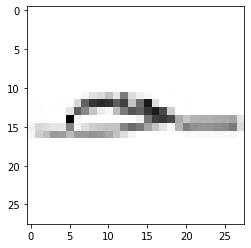

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Bag: 0.000


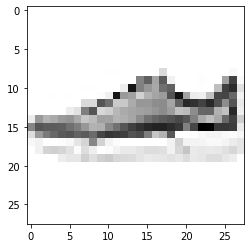

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Ankle boot: 0.000
	Sandal: 0.000


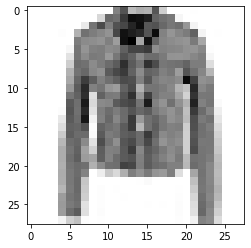

True label: Coat
Top 3 predictions:
	Coat: 0.991
	Shirt: 0.009
	Pullover: 0.001


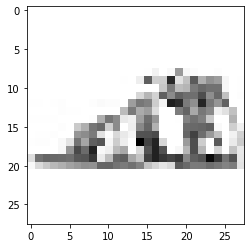

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Shirt: 0.000


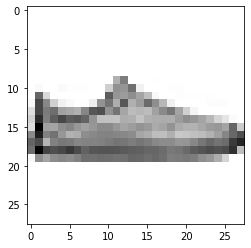

True label: Sneaker
Top 3 predictions:
	Sandal: 0.465
	Sneaker: 0.344
	Bag: 0.190


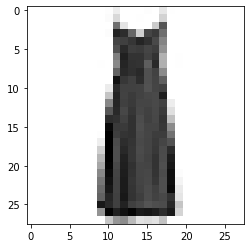

True label: Dress
Top 3 predictions:
	Dress: 1.000
	T-shirt/top: 0.000
	Coat: 0.000


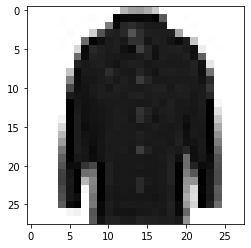

True label: Coat
Top 3 predictions:
	Coat: 0.969
	Pullover: 0.029
	Shirt: 0.002


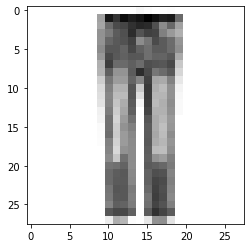

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


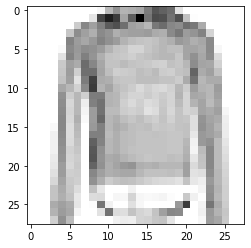

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	Shirt: 0.000
	T-shirt/top: 0.000


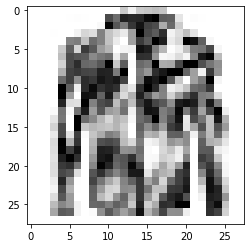

True label: Coat
Top 3 predictions:
	Coat: 0.998
	Shirt: 0.002
	Pullover: 0.000


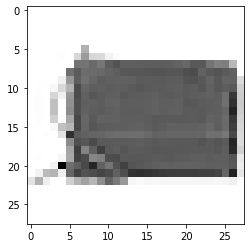

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Shirt: 0.000
	Pullover: 0.000


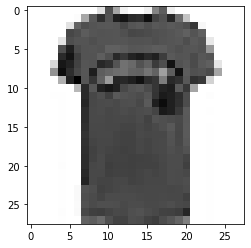

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.996
	Shirt: 0.004
	Pullover: 0.000


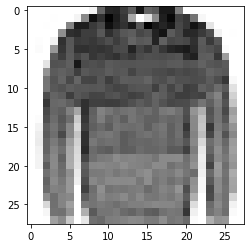

True label: Pullover
Top 3 predictions:
	Pullover: 0.993
	T-shirt/top: 0.006
	Shirt: 0.001


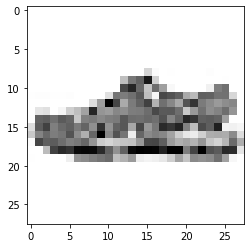

True label: Sandal
Top 3 predictions:
	Sandal: 0.999
	Sneaker: 0.001
	Ankle boot: 0.000


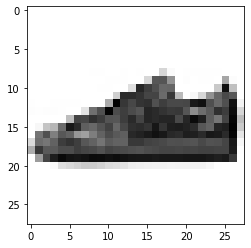

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.999
	Ankle boot: 0.000
	Bag: 0.000


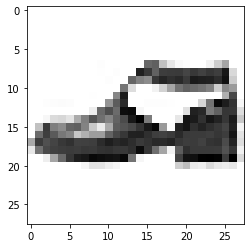

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.997
	Ankle boot: 0.002
	Sneaker: 0.000


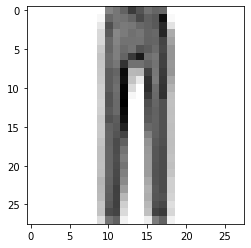

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	T-shirt/top: 0.000


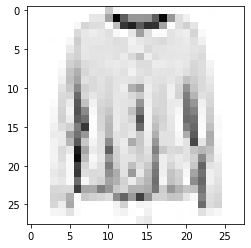

True label: Coat
Top 3 predictions:
	Shirt: 0.449
	Pullover: 0.363
	Coat: 0.188


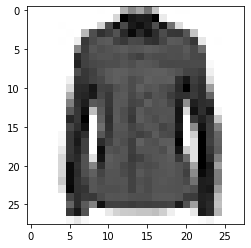

True label: Shirt
Top 3 predictions:
	Shirt: 0.970
	Coat: 0.026
	Pullover: 0.004


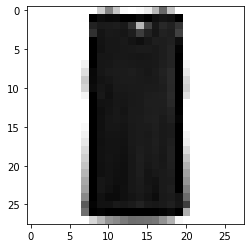

True label: T-shirt/top
Top 3 predictions:
	Shirt: 0.692
	T-shirt/top: 0.307
	Dress: 0.001


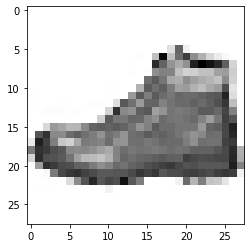

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.999
	Sneaker: 0.001
	Sandal: 0.000


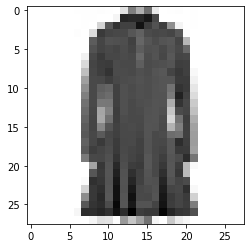

True label: Dress
Top 3 predictions:
	Dress: 0.635
	Coat: 0.284
	Shirt: 0.073


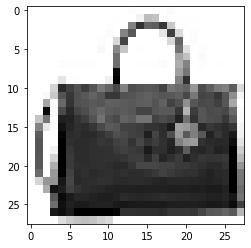

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


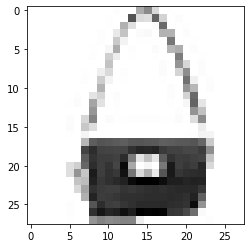

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Coat: 0.000


In [26]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Add Pooling, Batchnorm and Dropout

## Network

Let's add pooling, batchnorm and dropout layers. Adding a batchnorm layer allows us to increase the learning rate without losing stability. Take, for example, the learning rate 0.03 instead 0.01 (you can independently check what happens if you increase the learning rate without using a batchnorm layer).

In [27]:
class FashionMNISTModelCNNPoolingBN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.03):

        super(FashionMNISTModelCNNPoolingBN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv1_bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(784, 100)
        self.fc1_bn = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = x.flatten(1)
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [29]:
# Init our model
fmnist_model = FashionMNISTModelCNNPoolingBN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=10)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | fc1      | Linear      | 78.5 K
1 | fc2      | Linear      | 1.0 K 
2 | fc3      | Linear      | 1.0 K 
3 | conv1    | Conv2d      | 40    
4 | conv1_bn | BatchNorm2d | 8     
5 | fc1_bn   | BatchNorm1d | 200   
6 | dropout  | Dropout     | 0     
-----------------------------------------
80.8 K    Trainable params
0         Non-trainable params
80.8 K    Total params
0.323     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Testing

Restoring states from the checkpoint path at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_3\checkpoints\epoch=9-step=15630.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_3\checkpoints\epoch=9-step=15630.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8996999859809875
        val_loss            0.2715507447719574
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


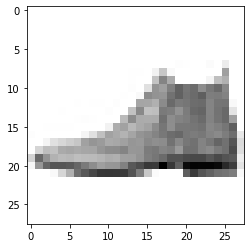

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.989
	Sneaker: 0.011
	Sandal: 0.000


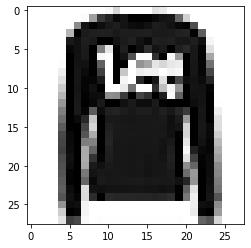

True label: Pullover
Top 3 predictions:
	Pullover: 0.951
	Shirt: 0.046
	Coat: 0.001


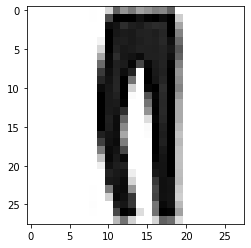

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Shirt: 0.000
	T-shirt/top: 0.000


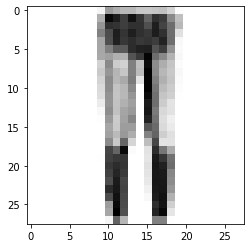

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


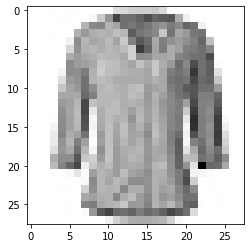

True label: Shirt
Top 3 predictions:
	T-shirt/top: 0.668
	Shirt: 0.266
	Pullover: 0.062


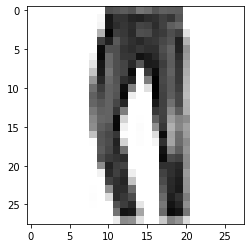

True label: Trouser
Top 3 predictions:
	Trouser: 0.997
	T-shirt/top: 0.001
	Shirt: 0.001


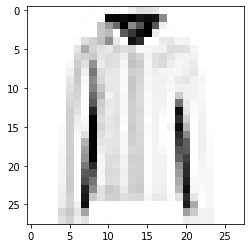

True label: Coat
Top 3 predictions:
	Coat: 0.978
	Pullover: 0.017
	Shirt: 0.005


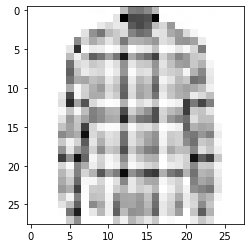

True label: Shirt
Top 3 predictions:
	Shirt: 0.978
	Coat: 0.017
	Pullover: 0.002


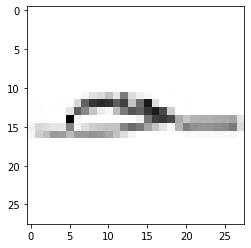

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Bag: 0.000
	Sneaker: 0.000


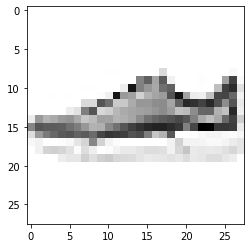

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.997
	Sandal: 0.003
	Ankle boot: 0.000


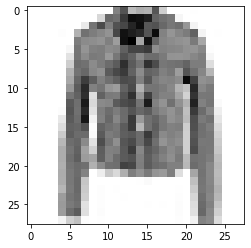

True label: Coat
Top 3 predictions:
	Coat: 0.603
	Pullover: 0.368
	Shirt: 0.028


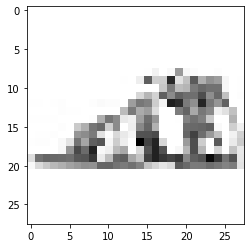

True label: Sandal
Top 3 predictions:
	Sandal: 0.804
	Sneaker: 0.122
	Ankle boot: 0.075


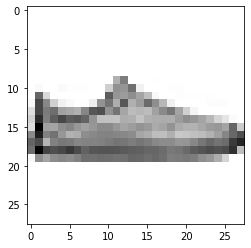

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.434
	Sandal: 0.368
	Bag: 0.195


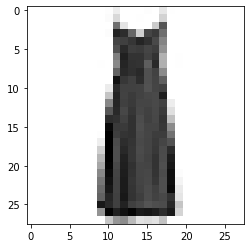

True label: Dress
Top 3 predictions:
	Dress: 1.000
	Bag: 0.000
	Ankle boot: 0.000


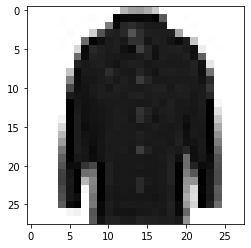

True label: Coat
Top 3 predictions:
	Coat: 0.938
	Pullover: 0.041
	Shirt: 0.019


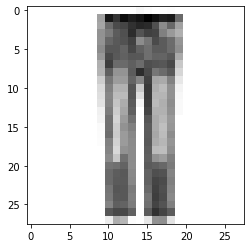

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


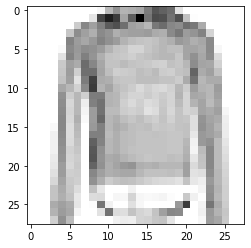

True label: Pullover
Top 3 predictions:
	Pullover: 0.924
	Shirt: 0.075
	T-shirt/top: 0.001


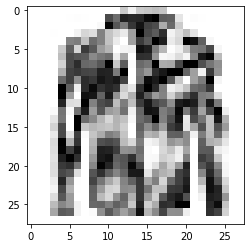

True label: Coat
Top 3 predictions:
	Coat: 0.763
	Shirt: 0.178
	Pullover: 0.059


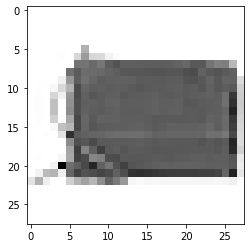

True label: Bag
Top 3 predictions:
	Bag: 0.999
	Coat: 0.000
	Trouser: 0.000


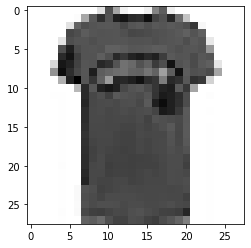

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.991
	Shirt: 0.008
	Pullover: 0.001


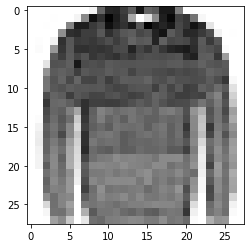

True label: Pullover
Top 3 predictions:
	Pullover: 0.981
	T-shirt/top: 0.011
	Shirt: 0.005


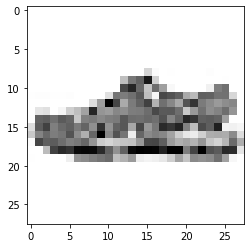

True label: Sandal
Top 3 predictions:
	Sandal: 0.896
	Sneaker: 0.103
	Ankle boot: 0.000


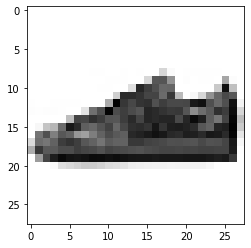

True label: Sneaker
Top 3 predictions:
	Sneaker: 0.995
	Ankle boot: 0.005
	Sandal: 0.000


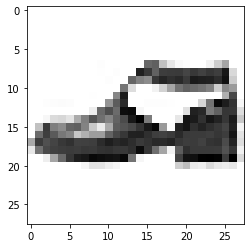

True label: Ankle boot
Top 3 predictions:
	Sandal: 0.999
	Sneaker: 0.001
	Ankle boot: 0.001


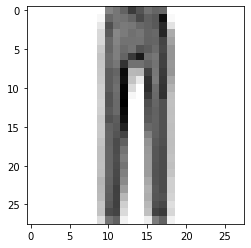

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Coat: 0.000


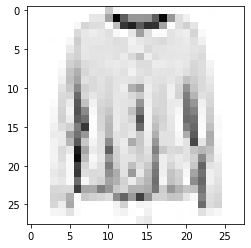

True label: Coat
Top 3 predictions:
	Shirt: 0.454
	Coat: 0.375
	Pullover: 0.163


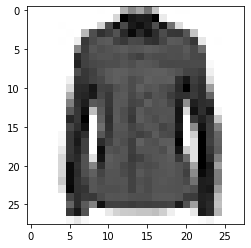

True label: Shirt
Top 3 predictions:
	Shirt: 0.755
	Pullover: 0.139
	Coat: 0.085


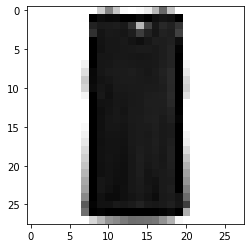

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.865
	Shirt: 0.068
	Dress: 0.066


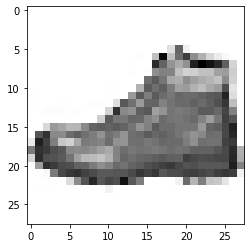

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.974
	Sneaker: 0.026
	Sandal: 0.000


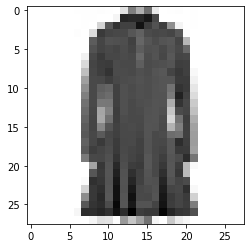

True label: Dress
Top 3 predictions:
	T-shirt/top: 0.382
	Dress: 0.244
	Shirt: 0.210


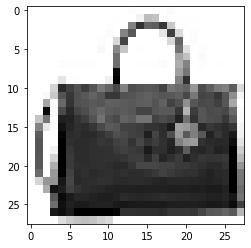

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	Sneaker: 0.000


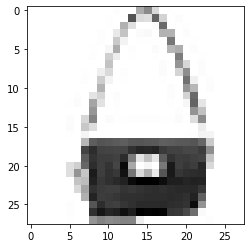

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Dress: 0.000
	Sandal: 0.000


In [30]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

## Result

Admire how more efficient convolutional networks are! We used only one convolutional layer with pooling, batchnorm and dropout. As result, we got much better accuracy obtained using a fully connected network with significantly fewer parameters (**80.8K** versus **454K**).

## Task 2

Now it's your turn again. Impove your CNN network with pooling and batchnorm to achive **0.91 accuracy** on validation.

1. add one more CNN layer with Batchnorm, ReLU and max pooling;
2. add one more FC layer with Batchnorm and ReLU; 
3. add Batchnorm to the penultimate FC-layer;
4. add Dropout layers after Flatten and FC layres (see example above).

Eventually, the network should be look like:

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1            [-1, 4, 28, 28]              40
            Conv2d-2           [-1, 16, 28, 28]             592
       BatchNorm2d-3           [-1, 16, 28, 28]              32
           Dropout-4                 [-1, 3136]               0
            Linear-5                 [-1, 1024]       3,212,288
       BatchNorm1d-6                 [-1, 1024]           2,048
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 100]         102,500
       BatchNorm1d-9                  [-1, 100]             200
          Dropout-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
================================================================
Total params: 3,318,710
Trainable params: 3,318,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 12.66
Estimated Total Size (MB): 12.93
----------------------------------------------------------------
```

In [38]:
class MySuperFashionMNISTModelCNNPoolingBN(FashionMNISTModelFC):

    def __init__(self, data_dir=DATA_DIR, learning_rate=0.03):

        super(MySuperFashionMNISTModelCNNPoolingBN, self).__init__(learning_rate=learning_rate)

        # Define PyTorch model layers
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=4,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=4,
                               out_channels=16,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(3136, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 100)
        self.fc2_bn = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.flatten(1)
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [40]:
from torchsummary import summary

fmnist_model = MySuperFashionMNISTModelCNNPoolingBN().to(device)
summary(fmnist_model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 28, 28]           40
├─Conv2d: 1-2                            [-1, 16, 28, 28]          592
├─BatchNorm2d: 1-3                       [-1, 16, 28, 28]          32
├─Dropout: 1-4                           [-1, 3136]                --
├─Linear: 1-5                            [-1, 1024]                3,212,288
├─BatchNorm1d: 1-6                       [-1, 1024]                2,048
├─Dropout: 1-7                           [-1, 1024]                --
├─Linear: 1-8                            [-1, 100]                 102,500
├─BatchNorm1d: 1-9                       [-1, 100]                 200
├─Dropout: 1-10                          [-1, 100]                 --
├─Linear: 1-11                           [-1, 10]                  1,010
Total params: 3,318,710
Trainable params: 3,318,710
Non-trainable params: 0
Total mult-adds (M): 3.80
Input size (MB): 0.00
Forward/bac

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 28, 28]           40
├─Conv2d: 1-2                            [-1, 16, 28, 28]          592
├─BatchNorm2d: 1-3                       [-1, 16, 28, 28]          32
├─Dropout: 1-4                           [-1, 3136]                --
├─Linear: 1-5                            [-1, 1024]                3,212,288
├─BatchNorm1d: 1-6                       [-1, 1024]                2,048
├─Dropout: 1-7                           [-1, 1024]                --
├─Linear: 1-8                            [-1, 100]                 102,500
├─BatchNorm1d: 1-9                       [-1, 100]                 200
├─Dropout: 1-10                          [-1, 100]                 --
├─Linear: 1-11                           [-1, 10]                  1,010
Total params: 3,318,710
Trainable params: 3,318,710
Non-trainable params: 0
Total mult-adds (M): 3.80
Input size (MB): 0.00
Forward/bac

In [42]:
# Init our model
fmnist_model = MySuperFashionMNISTModelCNNPoolingBN().to(device)

# Initialize a trainer
trainer = pl.Trainer(gpus=1, max_epochs=20)

# Train the model ⚡
dm.setup(stage='fit')
trainer.fit(fmnist_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | fc1      | Linear      | 3.2 M 
1 | fc2      | Linear      | 102 K 
2 | fc3      | Linear      | 1.0 K 
3 | conv1    | Conv2d      | 40    
4 | conv2    | Conv2d      | 592   
5 | conv2_bn | BatchNorm2d | 32    
6 | fc1_bn   | BatchNorm1d | 2.0 K 
7 | fc2_bn   | BatchNorm1d | 200   
8 | dropout  | Dropout     | 0     
-----------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.275    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Task 2 testing

Restoring states from the checkpoint path at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_4\checkpoints\epoch=19-step=31260.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at D:\Study\ml4p\Topic 2.2\Batchnorm layer\lightning_logs\version_4\checkpoints\epoch=19-step=31260.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9218999743461609
        val_loss            0.3131842315196991
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


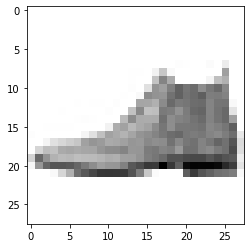

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sandal: 0.000
	T-shirt/top: 0.000


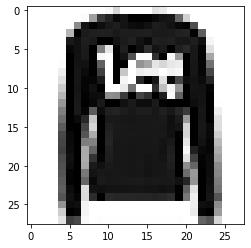

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	T-shirt/top: 0.000
	Dress: 0.000


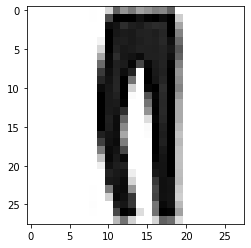

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Ankle boot: 0.000


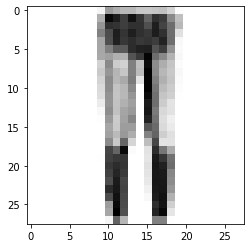

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Shirt: 0.000
	Dress: 0.000


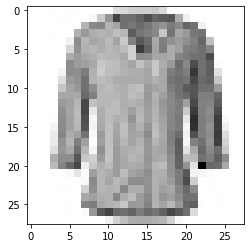

True label: Shirt
Top 3 predictions:
	Shirt: 0.704
	T-shirt/top: 0.295
	Pullover: 0.000


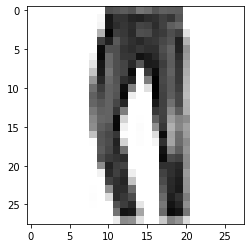

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Bag: 0.000
	Sandal: 0.000


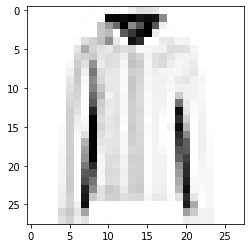

True label: Coat
Top 3 predictions:
	Coat: 1.000
	Shirt: 0.000
	Pullover: 0.000


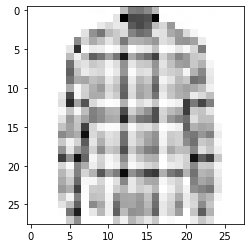

True label: Shirt
Top 3 predictions:
	Shirt: 1.000
	Pullover: 0.000
	Bag: 0.000


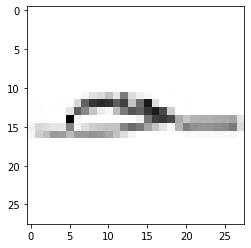

True label: Sandal
Top 3 predictions:
	Sandal: 0.999
	T-shirt/top: 0.000
	Sneaker: 0.000


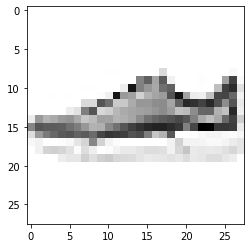

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Ankle boot: 0.000
	Sandal: 0.000


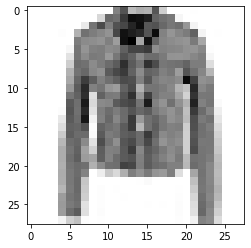

True label: Coat
Top 3 predictions:
	Coat: 1.000
	Pullover: 0.000
	Shirt: 0.000


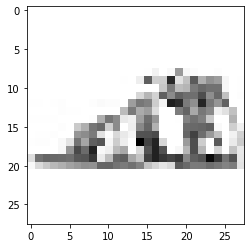

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Bag: 0.000


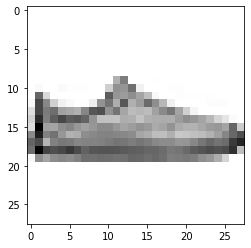

True label: Sneaker
Top 3 predictions:
	Sandal: 0.981
	Sneaker: 0.016
	Bag: 0.003


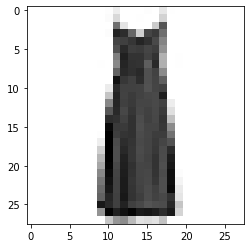

True label: Dress
Top 3 predictions:
	Dress: 1.000
	T-shirt/top: 0.000
	Shirt: 0.000


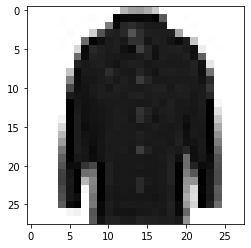

True label: Coat
Top 3 predictions:
	Coat: 0.947
	Pullover: 0.053
	T-shirt/top: 0.000


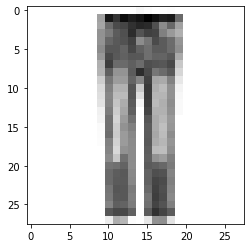

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Sandal: 0.000
	Dress: 0.000


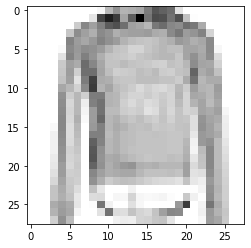

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	T-shirt/top: 0.000
	Shirt: 0.000


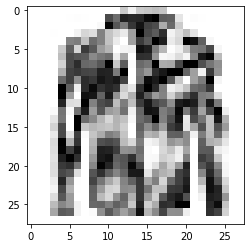

True label: Coat
Top 3 predictions:
	Coat: 0.474
	Shirt: 0.383
	Pullover: 0.143


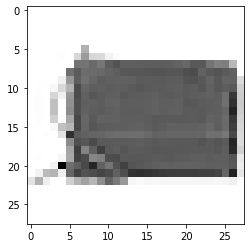

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Sandal: 0.000
	T-shirt/top: 0.000


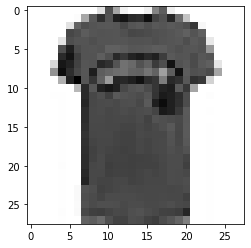

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 1.000
	Shirt: 0.000
	Ankle boot: 0.000


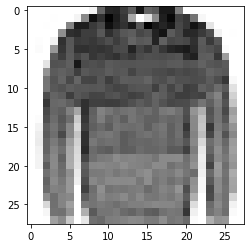

True label: Pullover
Top 3 predictions:
	Pullover: 1.000
	Shirt: 0.000
	Coat: 0.000


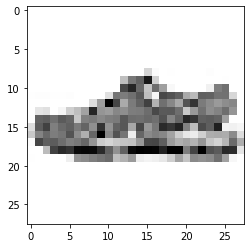

True label: Sandal
Top 3 predictions:
	Sandal: 1.000
	Sneaker: 0.000
	Ankle boot: 0.000


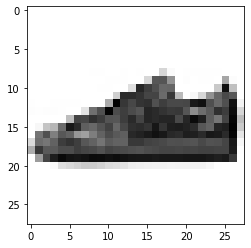

True label: Sneaker
Top 3 predictions:
	Sneaker: 1.000
	Sandal: 0.000
	Ankle boot: 0.000


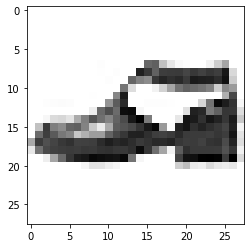

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 0.992
	Sandal: 0.005
	Sneaker: 0.003


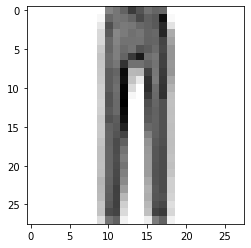

True label: Trouser
Top 3 predictions:
	Trouser: 1.000
	Dress: 0.000
	Sneaker: 0.000


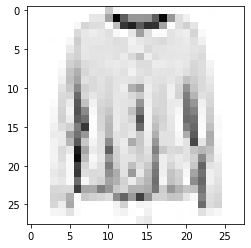

True label: Coat
Top 3 predictions:
	Pullover: 0.848
	Shirt: 0.110
	Coat: 0.041


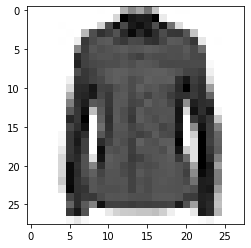

True label: Shirt
Top 3 predictions:
	Shirt: 0.995
	Pullover: 0.004
	Coat: 0.001


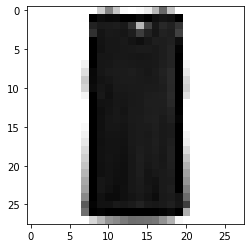

True label: T-shirt/top
Top 3 predictions:
	T-shirt/top: 0.834
	Shirt: 0.165
	Dress: 0.001


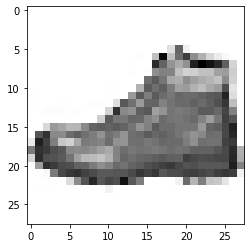

True label: Ankle boot
Top 3 predictions:
	Ankle boot: 1.000
	Sneaker: 0.000
	T-shirt/top: 0.000


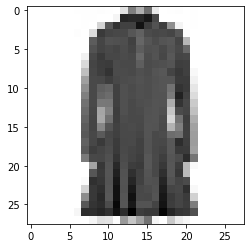

True label: Dress
Top 3 predictions:
	Dress: 0.947
	Shirt: 0.053
	Coat: 0.000


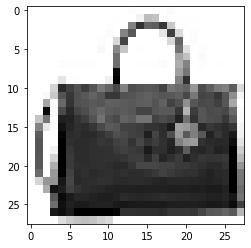

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Ankle boot: 0.000
	Sandal: 0.000


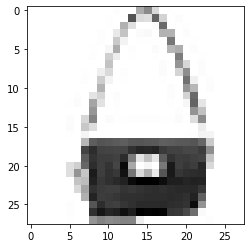

True label: Bag
Top 3 predictions:
	Bag: 1.000
	Ankle boot: 0.000
	Sandal: 0.000


In [43]:
dm.setup(stage='test')
trainer.test(datamodule=dm)

dataiter = iter(dm.test_dataloader())
images, labels = dataiter.next()
predictions = fmnist_model(images)

# show images
for idx in range(images.size()[0]):
    img = images[idx, 0]
    label = labels[idx]
    prediction = predictions[idx]
    matplotlib_imshow_apply_model(img, label, prediction)

# Conclusion

In this notebook, we switched from a fully-connected architecture to a convolutional one, which significantly increased the efficiency of the neural network. We also made sure that adding batchnorm, pooling and dropout layers can increase the training speed and reduce the amount of network weights.